# Merge the prophage counts based on the host's taxonomy

We are going to use the [GTDB](https://gtdb.ecogenomic.org/) taxonomy to count the number of prophages at different levels. Because of this, we merge with the GTDB metadata file.

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import numpy as np

import math
import re

from scipy.stats import pearsonr, f_oneway
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison

import subprocess
import gzip


In [2]:
# this is a neat trick for getting markdown in our output
# see https://stackoverflow.com/questions/23271575/printing-bold-colored-etc-text-in-ipython-qtconsole
# for the inspiration
from IPython.display import Markdown, display
def printmd(string, color="black"):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [3]:
#phagesdf = pd.read_csv("../small_data/phages_per_genome.tsv.gz", compression='gzip', header=0, delimiter="\t")
phagesdf = pd.read_csv("../data/phages_per_genome.tsv.gz", compression='gzip', header=0, delimiter="\t")
githash = subprocess.check_output(["git", "describe", "--always"]).strip().decode()
print(f"Please note that this was run with git commit {githash} that has {phagesdf.shape[0]:,} genomes parsed and {phagesdf['Total Predicted Prophages'].sum():,} total prophages")

Please note that this was run with git commit 1a3ab2a that has 399,582 genomes parsed and 14,967,114 total prophages


### Read the data file

The metadata is from GTDB. The phage data is from us.


In [4]:
gtdbfulldf = pd.read_csv("../data/bac120_metadata_r95.tsv.gz", compression='gzip', header=0, delimiter="\t")
gtdbfulldf

c:\workspace\edwa0468\githubs\phispyanalysis\venv\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (61,65,74,82,83) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,accession,ambiguous_bases,checkm_completeness,checkm_contamination,checkm_marker_count,checkm_marker_lineage,checkm_marker_set_count,checkm_strain_heterogeneity,coding_bases,coding_density,...,ssu_silva_blast_align_len,ssu_silva_blast_bitscore,ssu_silva_blast_evalue,ssu_silva_blast_perc_identity,ssu_silva_blast_subject_id,ssu_silva_taxonomy,total_gap_length,trna_aa_count,trna_count,trna_selenocysteine_count
0,GB_GCA_000006155.2,1916,93.12,0.00,1171,g__Bacillus (UID902),324,0.0,4305660,80.178992,...,none,none,none,none,none,none,42300,16,31,0
1,GB_GCA_000007385.1,0,99.82,0.00,481,c__Gammaproteobacteria (UID4202),276,0.0,4190634,84.805944,...,1541,2846,0,100,JXEG01000201.4293.5839,Bacteria;Proteobacteria;Gammaproteobacteria;Xa...,0,20,53,0
2,GB_GCA_000008605.1,67,100.00,0.00,235,f__Spirochaetaceae (UID2512),124,0.0,1048744,92.155875,...,1545,2854,0,100,CP003679.231299.232859,Bacteria;Spirochaetes;Spirochaetia;Spirochaeta...,0,20,45,0
3,GB_GCA_000010565.1,0,100.00,0.63,295,p__Firmicutes (UID1022),158,0.0,2608397,86.217312,...,1526,2819,0,100,AP009389.1049070.1050595,Bacteria;Firmicutes;Clostridia;Clostridiales;P...,0,20,51,1
4,GB_GCA_000013845.2,0,100.00,0.00,332,o__Clostridiales (UID1375),124,0.0,2428396,82.037966,...,1509,2787,0,100,CP000312.233320.234832,Bacteria;Firmicutes;Clostridia;Clostridiales;C...,0,20,95,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191522,RS_GCF_902166935.1,0,99.62,0.09,1312,g__Klebsiella (UID5140),336,0.0,4894244,87.293148,...,1536,2837,0,100,MAPL01000082.143.1696,Bacteria;Proteobacteria;Gammaproteobacteria;En...,0,20,87,1
191523,RS_GCF_902166945.1,0,99.94,0.72,1162,f__Enterobacteriaceae (UID5121),336,0.0,5162721,86.540042,...,1536,2837,0,100,CP016813.16076.17629,Bacteria;Proteobacteria;Gammaproteobacteria;En...,0,20,86,1
191524,RS_GCF_902167295.1,0,99.51,0.00,303,p__Bacteroidetes (UID2591),203,0.0,5737447,90.122088,...,1490,2747,0,99.933,JX101438.1.1490,Bacteria;Bacteroidetes;Bacteroidia;Chitinophag...,0,20,58,0
191525,RS_GCF_902167305.1,0,99.51,0.00,303,p__Bacteroidetes (UID2591),203,0.0,5738096,90.147873,...,1490,2747,0,99.933,JX101438.1.1490,Bacteria;Bacteroidetes;Bacteroidia;Chitinophag...,0,20,58,0


### Make sure we have the right column

PATRIC calls the column `assembly_accession` while GTDB calls it `ncbi_genbank_assembly_accession`

In [5]:
acccol = 'ncbi_genbank_assembly_accession'
gtdbfulldf[acccol]

0         GCA_000006155.2
1         GCA_000007385.1
2         GCA_000008605.1
3         GCA_000010565.1
4         GCA_000013845.2
               ...       
191522    GCA_902166935.1
191523    GCA_902166945.1
191524    GCA_902167295.1
191525    GCA_902167305.1
191526    GCA_902167325.1
Name: ncbi_genbank_assembly_accession, Length: 191527, dtype: object

### Abstract out the accession and name into new columns

This will allow us to merge the data with the PATRIC and GTDB data

In [6]:
def get_acc_name(x):
    regexp = re.compile('(\w+\.\d+)_([\w\.\-]+)_genomic.gbff.gz')
    m = regexp.match(x)
    if not m:
        sys.stderr.write(f"WARNING: Regexp did not match {x}\n")
        return (None, None)
    return list(m.groups())

phagesdf = pd.concat([pd.DataFrame.from_records(phagesdf['Contig'].apply(get_acc_name), columns=[acccol, 'Name']), phagesdf], axis=1)
phagesdf

,ncbi_genbank_assembly_accession,Name,Contig,Genome length,Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
0,GCA_000003135.1,ASM313v1,GCA_000003135.1_ASM313v1_genomic.gbff.gz,2396359,10,16,2,1,13,48916
1,GCA_000003645.1,ASM364v1,GCA_000003645.1_ASM364v1_genomic.gbff.gz,5269725,1,31,1,10,20,40297
2,GCA_000003925.1,ASM392v1,GCA_000003925.1_ASM392v1_genomic.gbff.gz,5561906,1,38,6,13,19,268081
3,GCA_000003955.1,ASM395v1,GCA_000003955.1_ASM395v1_genomic.gbff.gz,5790501,1,46,6,11,29,166286
4,GCA_000005825.2,ASM582v2,GCA_000005825.2_ASM582v2_genomic.gbff.gz,4249248,3,33,3,9,21,93416
...,...,...,...,...,...,...,...,...,...,...
399577,GCA_902860175.1,LMG_5997,GCA_902860175.1_LMG_5997_genomic.gbff.gz,7197255,21,33,2,14,17,69051
399578,GCA_902860185.1,LMG_6103,GCA_902860185.1_LMG_6103_genomic.gbff.gz,6497464,8,22,0,10,12,0
399579,GCA_902860195.1,LMG_7053,GCA_902860195.1_LMG_7053_genomic.gbff.gz,6702936,148,33,1,11,21,12819
399580,GCA_902860205.1,LMG_6001,GCA_902860205.1_LMG_6001_genomic.gbff.gz,6320373,19,35,2,21,12,41572


In [7]:
phagesdf[phagesdf[acccol] == 'GCA_000731785.1']

,ncbi_genbank_assembly_accession,Name,Contig,Genome length,Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
19093,GCA_000731785.1,ASM73178v1,GCA_000731785.1_ASM73178v1_genomic.gbff.gz,1000156,11,5,0,3,2,0


### Select some columns

## Sanity check

This is just to make sure that we are all working on the same data. Here, we make a temporary data frame that has the number of contigs and the number of basepairs in the genome, and use those to compare to see if we think we are working on the same thing.

If we find columns that are no good, we should delete them (but we don't, yay!)

In [8]:
def are_same(x):
    # currently fixing contig counts, so when that is done delete the next line and uncomment the one after
    return x['genome_size'] == x['Genome length']
    # return x['genome_size'] == x['Genome length'] and x['contig_count'] == x['Contigs']

comparison = pd.merge(gtdbfulldf[[acccol, 'contig_count', 'genome_size']],
                      phagesdf[[acccol, 'Name', 'Contigs', 'Genome length']],
                      how='inner', left_on=acccol, right_on=acccol)

comparison['same'] = comparison.apply(are_same, axis=1)
# look for rows that are not the same
comparison[comparison['same']==False]

,ncbi_genbank_assembly_accession,contig_count,genome_size,Name,Contigs,Genome length,same


## Filter the genomes

We should probably filter out based on quality. We have three quality scores (mimag high/medium/low) plus the number of contigs. Lets make a little violin plot of the quality vs Total or Kept prophages.


In [9]:
qual = pd.merge(gtdbfulldf[[acccol, 'checkm_completeness', 'gc_percentage', 'contig_count', 'genome_size', 'mimag_high_quality', 'mimag_low_quality', 'mimag_medium_quality']],
                phagesdf[[acccol, 'Total Predicted Prophages', 'Kept']],
                how='inner', left_on=acccol, right_on=acccol)
qual

,ncbi_genbank_assembly_accession,checkm_completeness,gc_percentage,contig_count,genome_size,mimag_high_quality,mimag_low_quality,mimag_medium_quality,Total Predicted Prophages,Kept
0,GCA_000006155.2,93.12,35.101404,426,5370060,f,f,t,5,0
1,GCA_000007385.1,99.82,63.693289,1,4941439,t,f,f,29,4
2,GCA_000008605.1,100.00,52.775181,1,1138011,t,f,f,5,1
3,GCA_000010565.1,100.00,52.961104,1,3025375,t,f,f,25,2
4,GCA_000013845.2,100.00,28.230917,4,2960088,t,f,f,12,2
...,...,...,...,...,...,...,...,...,...,...
122938,GCA_901482605.1,98.52,29.319857,1,2740791,t,f,f,16,5
122939,GCA_901482615.1,99.80,59.616313,1,6841780,t,f,f,30,6
122940,GCA_901482695.1,99.84,43.640897,1,5962893,t,f,f,32,4
122941,GCA_901687245.1,99.42,39.007844,42,1602364,f,f,t,7,0


In [10]:
def mimag_qual(x):
    if x['mimag_high_quality'] == 't':
        return "High"
    if x['mimag_medium_quality'] == 't':
        return "Medium"
    if x['mimag_low_quality'] == 't':
        return "Low"
    return "Unknown"

qual['Mimag quality'] = qual.apply(mimag_qual, axis=1)
qual

,ncbi_genbank_assembly_accession,checkm_completeness,gc_percentage,contig_count,genome_size,mimag_high_quality,mimag_low_quality,mimag_medium_quality,Total Predicted Prophages,Kept,Mimag quality
0,GCA_000006155.2,93.12,35.101404,426,5370060,f,f,t,5,0,Medium
1,GCA_000007385.1,99.82,63.693289,1,4941439,t,f,f,29,4,High
2,GCA_000008605.1,100.00,52.775181,1,1138011,t,f,f,5,1,High
3,GCA_000010565.1,100.00,52.961104,1,3025375,t,f,f,25,2,High
4,GCA_000013845.2,100.00,28.230917,4,2960088,t,f,f,12,2,High
...,...,...,...,...,...,...,...,...,...,...,...
122938,GCA_901482605.1,98.52,29.319857,1,2740791,t,f,f,16,5,High
122939,GCA_901482615.1,99.80,59.616313,1,6841780,t,f,f,30,6,High
122940,GCA_901482695.1,99.84,43.640897,1,5962893,t,f,f,32,4,High
122941,GCA_901687245.1,99.42,39.007844,42,1602364,f,f,t,7,0,Medium


In [11]:
phagesdf.columns

Index(['ncbi_genbank_assembly_accession', 'Name', 'Contig', 'Genome length',
       'Contigs', 'Total Predicted Prophages', 'Kept', 'No phage genes',
       'Not enough genes', 'bp prophage'],
      dtype='object')

In [12]:
qual[qual['Mimag quality'] == 'Unknown']

,ncbi_genbank_assembly_accession,checkm_completeness,gc_percentage,contig_count,genome_size,mimag_high_quality,mimag_low_quality,mimag_medium_quality,Total Predicted Prophages,Kept,Mimag quality
647,GCA_000448165.1,96.05,51.522661,127,2260155,f,f,f,37,3,Unknown
673,GCA_000480235.1,98.94,57.249530,30,3504296,f,f,f,10,1,Unknown
762,GCA_000555645.1,98.28,32.957739,58,3165229,f,f,f,11,6,Unknown
799,GCA_000682315.1,99.32,39.005359,589,4635745,f,f,f,99,5,Unknown
985,GCA_000954095.1,96.17,35.753954,656,3145901,f,f,f,26,0,Unknown
...,...,...,...,...,...,...,...,...,...,...,...
104428,GCA_006373885.1,100.00,45.501506,285,5115756,f,f,f,44,2,Unknown
104763,GCA_006385165.1,98.62,39.950964,8,2189419,f,f,f,25,1,Unknown
112165,GCA_900103395.1,99.68,59.189659,26,6477618,f,f,f,36,5,Unknown
112193,GCA_900103765.1,99.68,59.153631,26,6562057,f,f,f,36,7,Unknown


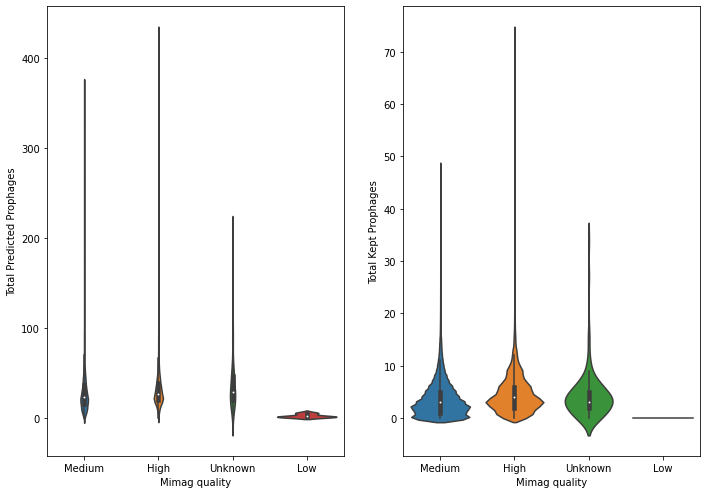

In [13]:
fig, ax = plt.subplots(1,2, figsize=(11.7,8.27))

sns.violinplot(x='Mimag quality', y='Total Predicted Prophages', jitter=True, data=qual, ax=ax[0])
#sns.stripplot(x='Mimag quality', y='Total Predicted Prophages',  jitter=True, data=qual, alpha=0.1, ax=ax[0], color='k')

sns.violinplot(x='Mimag quality', y='Kept', jitter=True, data=qual, ax=ax[1])
#sns.stripplot(x='Mimag quality', y='Kept',  jitter=True, data=qual, color='k', alpha=0.1, ax=ax[1])
ax[1].set_ylabel("Total Kept Prophages")

plt.show()


### How does completeness/size compare with predictions?

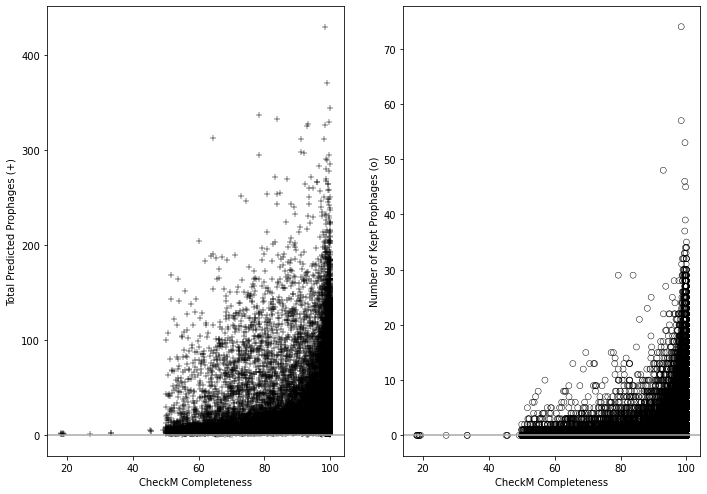

In [15]:
fig, ax = plt.subplots(1,2, figsize=(11.7,8.27))

sns.scatterplot(x='checkm_completeness', y='Total Predicted Prophages', data=qual, marker='+', color='k', ax=ax[0])
sns.scatterplot(x='checkm_completeness', y='Kept', data=qual, marker='o', facecolors='none', edgecolor='k', ax=ax[1])
# ax2.grid(False)
ax[1].set_ylabel('Number of Kept Prophages (o)')
ax[0].set_ylabel('Total Predicted Prophages (+)')
ax[0].set_xlabel('CheckM Completeness')
ax[1].set_xlabel('CheckM Completeness')
ax[0].axhline(y=0, color='darkgrey')
ax[1].axhline(y=0, color='darkgrey')

fig.savefig("images/checkm_vs_phages.svg")

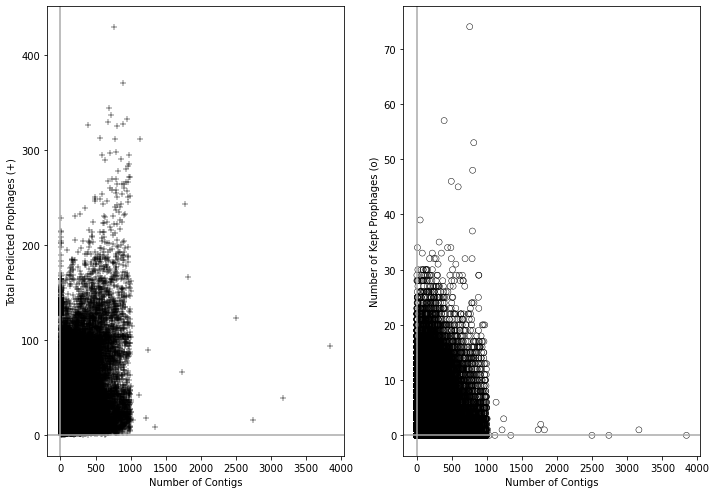

In [16]:
fig, ax = plt.subplots(1,2, figsize=(11.7,8.27))

sns.scatterplot(x='contig_count', y='Total Predicted Prophages', data=qual, marker='+', ax=ax[0], color='k')
sns.scatterplot(x='contig_count', y='Kept', data=qual, marker='o', facecolors='none', edgecolor='k', ax=ax[1])

ax[1].set_ylabel('Number of Kept Prophages (o)')
ax[0].set_ylabel('Total Predicted Prophages (+)')
ax[0].set_xlabel('Number of Contigs')
ax[1].set_xlabel('Number of Contigs')
ax[0].axhline(y=0, color='darkgrey')
ax[0].axvline(x=0, color='darkgrey')
ax[1].axhline(y=0, color='darkgrey')
ax[1].axvline(x=0, color='darkgrey')

fig.savefig("images/contigs_vs_phages.svg")


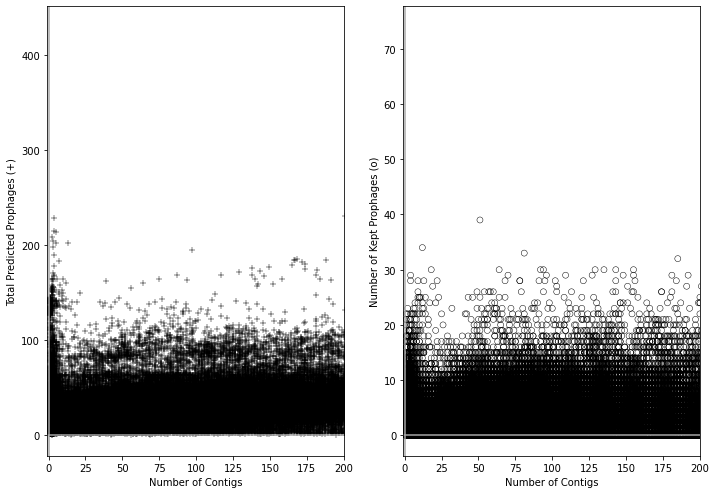

In [17]:
fig, ax = plt.subplots(1,2, figsize=(11.7,8.27))

sns.scatterplot(x='contig_count', y='Total Predicted Prophages', data=qual, marker='+', ax=ax[0], color='k')
sns.scatterplot(x='contig_count', y='Kept', data=qual, marker='o', facecolors='none', edgecolor='k', ax=ax[1])
ax[0].set_xlim(-1,200)
ax[1].set_xlim(-1,200)
ax[1].set_ylabel('Number of Kept Prophages (o)')
ax[0].set_ylabel('Total Predicted Prophages (+)')
ax[0].set_xlabel('Number of Contigs')
ax[1].set_xlabel('Number of Contigs')
ax[0].axhline(y=0, color='darkgrey')
ax[0].axvline(x=0, color='darkgrey')
ax[1].axhline(y=0, color='darkgrey')
ax[1].axvline(x=0, color='darkgrey')

fig.savefig("images/contigs_vs_phages_0200.svg")

At the moment there doesn't seem to be an obvious reason to cut or cull any of these predictions!

# Taxonomy

Extract the taxonomy from the GTDB table

### Split the taxonomy into separate columns

In [19]:
s = re.compile('^.__')
u = re.compile('_')
def split_taxonomy(x):
    p  = x.split(';')
    if len(p) != 7:
        sys.stderr.write("We have {len(p)} fields in {x}, but we expected 7 fields")
    # remove the prepended taxonomic rank name (e.g d__) and any remaining underscores before returning.
    return [u.sub(' ', l) for l in [s.sub('', m) for m in p] ]

In [20]:
# this is an example to make sure the split looks good. Returns an array
split_taxonomy(gtdbfulldf['gtdb_taxonomy'].iloc[0])

['Bacteria',
 'Firmicutes',
 'Bacilli',
 'Bacillales',
 'Bacillaceae G',
 'Bacillus A',
 'Bacillus A anthracis']

In [21]:
tc = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']
gc = ['accession', 'gtdb_genome_representative', 'gtdb_representative', 'gtdb_taxonomy', 'gtdb_type_designation', 'gtdb_type_designation_sources', 'gtdb_type_species_of_genus']
gtdbex = pd.concat([gtdbfulldf[acccol], pd.DataFrame.from_records(gtdbfulldf['gtdb_taxonomy'].apply(split_taxonomy), columns=tc), gtdbfulldf[gc]], axis=1)
gtdbex

,ncbi_genbank_assembly_accession,domain,phylum,class,order,family,genus,species,accession,gtdb_genome_representative,gtdb_representative,gtdb_taxonomy,gtdb_type_designation,gtdb_type_designation_sources,gtdb_type_species_of_genus
0,GCA_000006155.2,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae G,Bacillus A,Bacillus A anthracis,GB_GCA_000006155.2,RS_GCF_000534935.2,f,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,not type material,none,f
1,GCA_000007385.1,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Xanthomonas,Xanthomonas oryzae,GB_GCA_000007385.1,RS_GCF_004136375.1,f,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,not type material,none,f
2,GCA_000008605.1,Bacteria,Spirochaetota,Spirochaetia,Treponematales,Treponemataceae,Treponema,Treponema pallidum,GB_GCA_000008605.1,RS_GCF_000410535.2,f,d__Bacteria;p__Spirochaetota;c__Spirochaetia;o...,not type material,none,f
3,GCA_000010565.1,Bacteria,Firmicutes B,Desulfotomaculia,Desulfotomaculales,Pelotomaculaceae,Pelotomaculum,Pelotomaculum thermopropionicum,GB_GCA_000010565.1,GB_GCA_000010565.1,t,d__Bacteria;p__Firmicutes_B;c__Desulfotomaculi...,type strain of species,LPSN; DSMZ; StrainInfo,t
4,GCA_000013845.2,Bacteria,Firmicutes A,Clostridia,Clostridiales,Clostridiaceae,Clostridium P,Clostridium P perfringens,GB_GCA_000013845.2,RS_GCF_000013285.1,f,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__C...,not type material,none,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191522,GCA_902166935.1,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Klebsiella,Klebsiella pneumoniae,RS_GCF_902166935.1,RS_GCF_000742135.1,f,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,not type material,none,f
191523,GCA_902166945.1,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Klebsiella,Klebsiella pneumoniae,RS_GCF_902166945.1,RS_GCF_000742135.1,f,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,not type material,none,f
191524,GCA_902167295.1,Bacteria,Bacteroidota,Bacteroidia,Chitinophagales,Chitinophagaceae,Chitinophaga,Chitinophaga pinensis A,RS_GCF_902167295.1,RS_GCF_902167325.1,f,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,not type material,none,f
191525,GCA_902167305.1,Bacteria,Bacteroidota,Bacteroidia,Chitinophagales,Chitinophagaceae,Chitinophaga,Chitinophaga pinensis A,RS_GCF_902167305.1,RS_GCF_902167325.1,f,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,not type material,none,f


### Do we need to combine to different levels

We can combined e.g. from Bacteria to Order. But do we need to?

In [22]:
toorder = len(pd.unique(gtdbex.apply(lambda x: '_'.join(x[1:5].values.tolist()), axis=1)))
uniqueorder = len(pd.unique(gtdbex['order']))
print(f"Unique orders: {uniqueorder} Unique to order: {toorder}")

Unique orders: 930 Unique to order: 930


We have the same number of unique orders, so we can just use that as a unique key. However, I think we will still join them

## Merge the data frames

Merge the GTDB taxonomy with the prophage counts into a single df

In [23]:
phagegtdb = pd.merge(gtdbex, phagesdf, how='inner', left_on=acccol, right_on=acccol)
phagegtdb

,ncbi_genbank_assembly_accession,domain,phylum,class,order,family,genus,species,accession,gtdb_genome_representative,...,gtdb_type_species_of_genus,Name,Contig,Genome length,Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
0,GCA_000006155.2,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae G,Bacillus A,Bacillus A anthracis,GB_GCA_000006155.2,RS_GCF_000534935.2,...,f,ASM615v2,GCA_000006155.2_ASM615v2_genomic.gbff.gz,5370060,3,5,0,2,3,0
1,GCA_000007385.1,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Xanthomonas,Xanthomonas oryzae,GB_GCA_000007385.1,RS_GCF_004136375.1,...,f,ASM738v1,GCA_000007385.1_ASM738v1_genomic.gbff.gz,4941439,1,29,4,12,13,129141
2,GCA_000008605.1,Bacteria,Spirochaetota,Spirochaetia,Treponematales,Treponemataceae,Treponema,Treponema pallidum,GB_GCA_000008605.1,RS_GCF_000410535.2,...,f,ASM860v1,GCA_000008605.1_ASM860v1_genomic.gbff.gz,1138011,1,5,1,2,2,48873
3,GCA_000010565.1,Bacteria,Firmicutes B,Desulfotomaculia,Desulfotomaculales,Pelotomaculaceae,Pelotomaculum,Pelotomaculum thermopropionicum,GB_GCA_000010565.1,GB_GCA_000010565.1,...,t,ASM1056v1,GCA_000010565.1_ASM1056v1_genomic.gbff.gz,3025375,1,25,2,9,14,107997
4,GCA_000013845.2,Bacteria,Firmicutes A,Clostridia,Clostridiales,Clostridiaceae,Clostridium P,Clostridium P perfringens,GB_GCA_000013845.2,RS_GCF_000013285.1,...,f,ASM1384v2,GCA_000013845.2_ASM1384v2_genomic.gbff.gz,2960088,4,12,2,4,6,56955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122938,GCA_901482605.1,Bacteria,Firmicutes A,Clostridia,Clostridiales,Clostridiaceae,Hathewaya,Hathewaya histolytica,RS_GCF_901482605.1,RS_GCF_901482605.1,...,t,45532_E01,GCA_901482605.1_45532_E01_genomic.gbff.gz,2740791,1,16,5,4,7,177991
122939,GCA_901482615.1,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas E,Pseudomonas E synxantha,RS_GCF_901482615.1,RS_GCF_900105675.1,...,f,45076_A01,GCA_901482615.1_45076_A01_genomic.gbff.gz,6841780,1,30,6,2,22,196417
122940,GCA_901482695.1,Bacteria,Bacteroidota,Bacteroidia,Sphingobacteriales,Sphingobacteriaceae,Sphingobacterium,Sphingobacterium thalpophilum,RS_GCF_901482695.1,RS_GCF_901482695.1,...,f,45076_G02,GCA_901482695.1_45076_G02_genomic.gbff.gz,5962893,1,32,4,6,22,130705
122941,GCA_901687245.1,Bacteria,Campylobacterota,Campylobacteria,Campylobacterales,Helicobacteraceae,Helicobacter,Helicobacter pylori,RS_GCF_901687245.1,RS_GCF_900478295.1,...,f,25455_8_248,GCA_901687245.1_25455_8_248_genomic.gbff.gz,1602364,18,7,0,3,4,0


In [27]:
phagegtdb[phagegtdb['phylum'] == '4572-55']

,ncbi_genbank_assembly_accession,domain,phylum,class,order,family,genus,species,accession,gtdb_genome_representative,...,Name,Contig,Genome length,Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage,to_order
4466,GCA_002084765.1,Bacteria,4572-55,4572-55,4572-55,4572-55,4572-55,4572-55 sp002084765,GB_GCA_002084765.1,GB_GCA_002084765.1,...,ASM208476v1,GCA_002084765.1_ASM208476v1_genomic.gbff.gz,4085200,110,11,0,5,6,0,Bacteria::4572-55::4572-55::4572-55
11387,GCA_003697105.1,Bacteria,4572-55,4572-55,J002,J002,J002,J002 sp003697105,GB_GCA_003697105.1,GB_GCA_003697105.1,...,ASM369710v1,GCA_003697105.1_ASM369710v1_genomic.gbff.gz,4180380,174,29,2,13,14,46926,Bacteria::4572-55::4572-55::J002


### Combine the data.

This is the general approach to combine the data. Here we combine everything upto order into a new column and then aggregate by that new column.

In [26]:
phagegtdb['to_order'] = phagegtdb.apply(lambda x: '::'.join(x[1:5].values.tolist()), axis=1)
phagegtdb.groupby('to_order').aggregate({'Kept' : 'sum'})

,Kept
to_order,
Bacteria::4572-55::4572-55::4572-55,0
Bacteria::4572-55::4572-55::J002,2
Bacteria::AABM5-125-24::AABM5-125-24::BMS3BBIN04,0
Bacteria::AABM5-125-24::B3-LCP::B3-LCP,4
Bacteria::AABM5-125-24::RPQS01::RPQS01,0
...,...
Bacteria::Zixibacteria::MSB-5A5::DG-27,0
Bacteria::Zixibacteria::MSB-5A5::GN15,0
Bacteria::Zixibacteria::MSB-5A5::MSB-5A5,1


In [ ]:
gtdbex['to_order'] = gtdbex.apply(lambda x: '_'.join(x[1:5].values.tolist()), axis=1)
seen = {}
for o, too in zip(gtdbex.order, gtdbex.to_order):
    if o in seen and seen[o] != too:
        print(f"For {o} had {seen[o]} but now {too}")
    seen[o] = too

### Aggregate using phylum and the mean

In fact, we want to aggregate the different phyla and then take the mean of the number of prophages per phyla.

In [ ]:
taxadf[taxadf['order'] == 'o:']

In [ ]:
taxadf['to_phylum'] = taxadf.apply(lambda x: '_'.join(x[2:4].values.tolist()), axis=1)
tp = taxadf.groupby('to_phylum').aggregate({'prophages' : 'mean'})
tp

Here, we replace the names in the index. Note that we only have bacteria, so we can drop that, and don't get me started on _Candidatus_. So we remove that too. After removing everything, we sort the table by this column and then  use it as the index. Finally, we remove the row that has no taxonomic information

In [ ]:
# remove Bacteria and Candidatus and then sort the data
text_rename = lambda x: x.replace('s:Bacteria_p:', '').replace('Candidatus ', '')
tp = taxadf.groupby('to_phylum').aggregate({'prophages' : 'mean'})
tp = tp.reset_index()
tp['to_phylum'] = tp['to_phylum'].apply(text_rename)
tp = tp.sort_values('to_phylum').set_index('to_phylum')
tp = tp.iloc[1:]
tp

### Make a plot

This makes a plot of the data, and sets the labels to be readable.

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(23.4,16.54))
sns.barplot(x=tp.index, y='prophages', data=tp, ax=ax, color='b')

# get the tick labels and change some parameters about them.
ticks_loc = ax.get_xticklabels()
l = ax.set_xticklabels(ticks_loc, rotation=90, horizontalalignment='center', fontsize=12)
# use this to hide every other tick
# [x.set_visible(False) for x in l[::2]]

# add a slight offset for every other tick label
for alab in l[::2]:
    x, y = alab.get_position()
    alab.set_position((x, y-0.01))

# turn off the ticks themselves
ax.tick_params(length=0, pad=0)
ax.set_ylabel('Mean number of prophages per phylum')
plt.tight_layout()
fig.savefig('images/phyla.tiff')

In [ ]:
taxadf[['to_phylum', 'prophages']]

# Statistical Analyses

Some stats on the number of prophages per taxonomic classification

# Effect Size Calculations

Our datasets are so large that even small effect sizes may have statistically significant differences. There is lots of discussion about this, for example see these posts and articles:

* [Effect size, confidence interval and statistical significance: a practical guide for biologists](https://people.kth.se/~lang/Effect_size.pdf)
* [It's the Effect Size, Stupid! What effect size is and why it is important](http://www.leeds.ac.uk/educol/documents/00002182.htm)
* [Large scale statistical analysis discussion on stats stackexchange](https://stats.stackexchange.com/questions/7815/what-skills-are-required-to-perform-large-scale-statistical-analyses)
* [Large data sets and hypothesis testing](https://stats.stackexchange.com/questions/2516/are-large-data-sets-inappropriate-for-hypothesis-testing)
* [The Dangers of Large Data Sets: A Tale of P values, Error Rates, and Bonferroni Corrections](https://thelogicofscience.com/2015/04/07/basic-statistics-part-3-the-dangers-of-large-data-sets-a-tale-of-p-values-error-rates-and-bonferroni-corrections/)
* [The Unofficial Google Data Blog](http://www.unofficialgoogledatascience.com/2016/10/practical-advice-for-analysis-of-large.html)

Because of these concerns, we include two measures of effect size.

## Cohen's f<sup>2</sup>

This is a measure of the effect size from the ANOVA:

f<sup>2</sup> = &#x003B7;<sup>2</sup>/(1 - &#x003B7;<sup>2</sup>)

This measures the combined effect size, and does not provide a pairwise comparison of the data.

According to Cohen (1988; pg. 413; Chapter 9) the effect sizes are: 

 * small effect size: f<sup>2</sup> = 0.02
 * medium effect size: f<sup>2</sup> = 0.15
 * large effect size: f<sup>2</sup> = 0.35

See chapter 9 of [Cohen J. E. (1988). Statistical Power Analysis for the Behavioral Sciences. Hillsdale, NJ: Lawrence Erlbaum Associates, Inc](http://www.utstat.toronto.edu/~brunner/oldclass/378f16/readings/CohenPower.pdf)

# Cohen's d

This is a pairwise measure of the effect size, and can be used to compare our different groups or samples thereof.

According to Cohen (1988; pg. 26; Chapter 2) the effect sizes are:

 * small effect size: d = 0.2
 * medium effect size: d = 0.5
 * large effect size: d = 0.8
 
For a detailed exposition, see chapter 2 of [Cohen J. E. (1988). Statistical Power Analysis for the Behavioral Sciences. Hillsdale, NJ: Lawrence Erlbaum Associates, Inc](http://www.utstat.toronto.edu/~brunner/oldclass/378f16/readings/CohenPower.pdf)

In [ ]:
def cohen_f(ssr,sse):
    """
    Calculate Cohen's f-squared from the Sum of Squares of Regression (SSR)
    and the Sum of Squares of Error (SSE).
    
    SSR is from the anova table as aov_table['sum_sq'][0]
    SSE is from the anova table as aov_table['sum_sq'][1]
    """
    
    rsq = ssr / (ssr + sse) # R^2 = SSR/SST
    return rsq / (1-rsq)

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    d = (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)
    if np.isnan(d):
        # sys.stderr.write(f"{x} ~ {y} returned NaN\n")
        return 0
    return d

## Summary Statistics

This will be useful in our paper!

# Make sure the data is the same.

We are going to check the number of contigs, the number of basepairs

In [ ]:
print("Phylum\tMinimum number of prophages\tMaximum number of prophages\tMean number of prophages\tMedian number of prophages\tStandard deviation")
for p in sorted(pd.unique(taxadf.to_phylum)):
    if len(text_rename(p)) == 0:
        continue
    d = taxadf[taxadf.to_phylum == p]
    count = d.prophages.count()
    m = d.prophages.min()
    x = d.prophages.max()
    n = round(d.prophages.mean(), 2)
    e = round(d.prophages.median(), 2)
    s = round(d.prophages.std(), 2)
    #print(f"Phylum: {text_rename(p)}, Min: {m}, Max: {x}, Mean: {n}, Median: {e}, stdev: {s}")
    #printmd(f"{text_rename(p)} (n: {count}, *M* = {n}, *SD* = {s})")
    print("\t".join(map(str, [text_rename(p), m, x, n, e, s])))

# Anovas

I've used two different ways to calculate the ANOVA. The first is using _scipy.stats_ function _f\_oneway_ and the second is with statsmodels

### Calculate the one-way anova for all the data

Here, we group by _to_phylum_ and then compare the number of prophages in each group. Note that _group\_by_ returns a tuple of the grouped by name and the dataframe for that group, so _names_ is an array of the names and has the same dimension as _samples_. The 2D array _samples_ has one dimension for each name and the other for the number of prophages for that name.

In [ ]:
samples = []
names = []
for nm, groupdf in taxadf.groupby('to_phylum'):
    names.append(nm)
    samples.append(groupdf['prophages'])
f_val, p_val = f_oneway(*samples)
print('F value: {:.3f}, p value: {:.3f}'.format(f_val, p_val))

### Repeat for order

Is there a significant difference in order

In [ ]:
samples = []
names = []
for nm, groupdf in taxadf.groupby('to_order'):
    names.append(nm)
    samples.append(groupdf['prophages'])
f_val, p_val = f_oneway(*samples)
print('F value: {:.3f}, p value: {:.3f}'.format(f_val, p_val))

### Using statsmodels

Note that we have two measures of _phylum_: **phylum** is the actual phyla itself, while **to_phylum** is the concatenation of everything upto phylum.

For _phylum_ it doesn't matter, but for order it may (not sure if the orders are unique by themselves).


In [ ]:
mod = ols('prophages ~ phylum', data=taxadf).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)
print()
printmd("Report as: *F*({}, {}) = {}, *p* = {}".format(
    int(aov_table.df['phylum']), 
    int(aov_table.df['Residual']),
    round(aov_table.F['phylum'], 2),
    round(aov_table.get("PR(>F)")['phylum'], 4)
))

In [ ]:
mod = ols('prophages ~ to_phylum', data=taxadf).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)
print()
printmd("Report as: *F*({}, {}) = {}, *p* = {}".format(
    int(aov_table.df['to_phylum']), 
    int(aov_table.df['Residual']),
    round(aov_table.F['to_phylum'], 2),
    round(aov_table.get("PR(>F)")['to_phylum'], 4)
))

### Use Tukey's honestly significant difference test to compare the data

This performs pairwise comparisons on our data. The NULL hypothesis is that there is no statistical difference in the means of the two samples. If we reject that NULL hypothesis (reject == True) then we have reason to believe that there is a significan difference in the means of the samples.

In [ ]:
rec = pairwise_tukeyhsd(taxadf['prophages'], taxadf['phylum'])
print(rec)

In [ ]:
tukeysres = pd.DataFrame(data=rec._results_table.data[1:], columns=rec._results_table.data[0])
tukeysres[tukeysres['reject'] == True]

## Effect size

We measure the effect size of the group as a whole from the anova using Cohen's f<sup>2</sup> and pairwise using Cohen's d.

In [ ]:
phyla = pd.unique(taxadf['phylum'])
for i, c in enumerate(phyla):
    for j in range(i, len(phyla)):
        d = phyla[j]
        if c == d:
            continue
        print("Cohen's d for {} - {}: {}".format(c, d, round(
            cohen_d(
                taxadf[taxadf['phylum'] == c]['prophages'], taxadf[taxadf['phylum'] == d]['prophages'], 
        ), 2)))

Make the effect size into a table so we can make a heat map of it!

In [ ]:
phyla = sorted(pd.unique(taxadf['phylum']))
cohend = pd.DataFrame(index=phyla, columns=phyla)
# now that we have created the dataframe, we need to coerce the columns to be numeric. 
for p in phyla:
    cohend[p] = pd.to_numeric(cohend[p])

for i, c in enumerate(phyla):
    for j in range(i, len(phyla)):
        d = phyla[j]
        if c == d:
            cohend.iloc[i, j] = 0
            continue
        cohend.iloc[i, j] = cohen_d(taxadf[taxadf['phylum'] == c]['prophages'], taxadf[taxadf['phylum'] == d]['prophages'])
        cohend.iloc[j, i] = -cohend.iloc[i, j]



In [ ]:
cohend

In [ ]:
sns.heatmap(cohend, cmap=sns.color_palette("light:b", as_cmap=True))

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(23.4,16.54))
sns.heatmap(cohend,  cmap=sns.color_palette("Spectral", as_cmap=True), ax=ax, xticklabels=1, yticklabels=1)


# get the tick labels and change some parameters about them.
xticks_loc = ax.get_xticklabels()
lx = ax.set_xticklabels(xticks_loc, fontsize=10)
# use this to hide every other tick
[x.set_visible(False) for x in lx[::2]]

yticks_loc = ax.get_yticklabels()
ly = ax.set_yticklabels(yticks_loc, fontsize=10)
# use this to hide every other tick
[y.set_visible(False) for y in ly[1::2]]


# add a slight offset for every other x tick label
for alab in lx[1::4]:
    x, y = alab.get_position()
    alab.set_position((x, y-0.01))

# add a slight offset for every other y tick label
for alab in ly[2::4]:
    x, y = alab.get_position()
    alab.set_position((x-0.01, y))




plt.tight_layout()
fig.savefig('images/cohen_heatmap.tiff')

In [ ]:
a=[1,2,3,4,5,6,7,8,9]
print(a[::2])
print(a[1::2])